# [3주차] 심화과제: Machine translation(기계 번역)

In [38]:
# !pip install tqdm boto3 requests regex sentencepiece sacremoses datasets safetensors transformers tokenizers matplotlib torchinfo tqdm sacrebleu pandas scikit-learn

# [MY CODE] Language Translation (English-French) dataset 준비

## ✅ 1. 데이터 불러오기 & 확인

In [39]:
import pandas as pd

eng_french_data = pd.read_csv('eng_-french.csv')
print(eng_french_data.shape)
print(eng_french_data.columns)
print(eng_french_data.head())

(175621, 2)
Index(['English words/sentences', 'French words/sentences'], dtype='object')
  English words/sentences French words/sentences
0                     Hi.                 Salut!
1                    Run!                Cours !
2                    Run!               Courez !
3                    Who?                  Qui ?
4                    Wow!             Ça alors !


## ✅ 2. 훈련/테스트 셋 분리 (Train/Test Split)

In [40]:
from sklearn.model_selection import train_test_split

# 훈련 데이터: 80%, 테스트 데이터: 20%
train_data, test_data = train_test_split(eng_french_data, test_size=0.2, random_state=42)

print(f"훈련 데이터 크기: {len(train_data)}")
print(f"테스트 데이터 크기: {len(test_data)}")

훈련 데이터 크기: 140496
테스트 데이터 크기: 35125


## ✅ 3. T5 토크나이저 준비 & 토크나이징

In [41]:
import torch
from transformers import T5Tokenizer
tokenizer = T5Tokenizer.from_pretrained('t5-small')  # t5-small, t5-base, t5-large

english_column = 'English words/sentences'
french_column  = 'French words/sentences'

# 훈련 및 테스트 데이터 토크나이징
train_encodings = tokenizer(list(train_data[english_column]), padding=True, truncation=True, max_length=512)
test_encodings = tokenizer(list(test_data[english_column]), padding=True, truncation=True, max_length=512)

# 라벨(프랑스어) 토크나이징
train_labels = tokenizer(list(train_data[french_column]), padding=True, truncation=True, max_length=512)
test_labels = tokenizer(list(test_data[french_column]), padding=True, truncation=True, max_length=512)

## ✅ 4. 데이터셋 클래스로 변환 (PyTorch Dataset)

In [42]:
import torch

class TranslationDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.encodings.input_ids)

    def __getitem__(self, idx):
        return {
            'input_ids': self.encodings['input_ids'][idx],
            'attention_mask': self.encodings['attention_mask'][idx],
            'labels': self.labels['input_ids'][idx],
        }

train_dataset = TranslationDataset(train_encodings, train_labels)
test_dataset = TranslationDataset(test_encodings, test_labels)

## ✅ 5. DataLoader 준비

In [43]:
from torch.utils.data import DataLoader

# collate_fn 정의
def collate_fn(batch):
    input_ids = torch.tensor([item['input_ids'] for item in batch])
    attention_mask = torch.tensor([item['attention_mask'] for item in batch])
    labels = torch.tensor([item['labels'] for item in batch])

    return {
        'input_ids': input_ids,
        'attention_mask': attention_mask,
        'labels': labels
    }



batch_size = 64

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

In [44]:
device = torch.device("cuda" if torch.cuda.is_available() else
                      "mps" if torch.backends.mps.is_available() else
                      "cpu")

print(f"Using device: {device}")

Using device: mps


In [50]:
import numpy as np
import matplotlib.pyplot as plt
import sacrebleu

def accuracy(model, dataloader, tokenizer):
    cnt = 0
    acc = 0

    model.eval()
    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch['input_ids'].to(device)
            labels = batch['labels'].to(device)

            # T5는 generate()를 사용해 예측 시퀀스를 생성
            preds = model.generate(input_ids=input_ids, max_length=labels.size(1))

            # 토큰 -> 텍스트로 변환 후 비교 (정확도 측정)
            pred_texts = [tokenizer.decode(p, skip_special_tokens=True) for p in preds]
            label_texts = [tokenizer.decode(l, skip_special_tokens=True) for l in labels]

            # 문장 단위 비교 (정확히 일치하는 문장만 정답으로 간주)
            for p, l in zip(pred_texts, label_texts):
                if p == l:
                    acc += 1
                cnt += 1

    return acc / cnt



# BLEU 점수 계산 함수 추가
def calculate_bleu(model, dataloader, tokenizer):
    model.eval()
    predictions = []
    references = []

    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch['input_ids'].to(device)
            labels = batch['labels'].to(device)

            outputs = model.generate(input_ids=input_ids, max_length=labels.size(1))

            pred_texts = [tokenizer.decode(output, skip_special_tokens=True) for output in outputs]
            ref_texts = [tokenizer.decode(label, skip_special_tokens=True) for label in labels]

            predictions.extend(pred_texts)
            references.extend(ref_texts)

    bleu_score = sacrebleu.corpus_bleu(predictions, [references]).score
    return bleu_score

def evaluate_model(model, dataloader, tokenizer):
    model.eval()
    predictions = []
    references = []
    acc = 0
    cnt = 0

    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch['input_ids'].to(device)
            labels = batch['labels'].to(device)

            # 예측 생성
            preds = model.generate(input_ids=input_ids, max_length=labels.size(1))

            # 토큰 -> 텍스트 변환
            pred_texts = [tokenizer.decode(p, skip_special_tokens=True) for p in preds]
            ref_texts = [tokenizer.decode(l, skip_special_tokens=True) for l in labels]

            # 정확도 계산 (문장 단위 비교)
            for p, l in zip(pred_texts, ref_texts):
                if p == l:
                    acc += 1
                cnt += 1

            # BLEU 계산을 위한 데이터 축적
            predictions.extend(pred_texts)
            references.extend(ref_texts)

    # BLEU 점수 계산
    bleu_score = sacrebleu.corpus_bleu(predictions, [references]).score
    accuracy = acc / cnt

    return accuracy, bleu_score


def evaluate_model(model, dataloader, tokenizer):
    model.eval()
    total_loss = 0
    predictions = []
    references = []
    acc = 0
    cnt = 0

    with torch.no_grad():
        print("Evaluating ...")
        for batch in tqdm(dataloader, desc="Evaluation"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            # 1) Loss 계산
            outputs = model(input_ids=input_ids,
                            attention_mask=attention_mask,
                            labels=labels)
            loss = outputs.loss
            total_loss += loss.item()

            # 2) generate()로 텍스트 예측
            preds = model.generate(input_ids=input_ids, max_length=labels.size(1))
            pred_texts = [tokenizer.decode(p, skip_special_tokens=True) for p in preds]
            ref_texts  = [tokenizer.decode(l, skip_special_tokens=True) for l in labels]

            # 3) Accuracy 계산
            for p, r in zip(pred_texts, ref_texts):
                if p == r:
                    acc += 1
                cnt += 1

            # 4) BLEU 계산용 데이터
            predictions.extend(pred_texts)
            references.extend(ref_texts)

    # 평균 Loss와 Perplexity
    avg_loss = total_loss / len(dataloader)
    ppl = torch.exp(torch.tensor(avg_loss))

    # BLEU 점수
    bleu_score = sacrebleu.corpus_bleu(predictions, [references]).score
    accuracy = acc / cnt

    return avg_loss, ppl, accuracy, bleu_score

def to_float_list(values):
        """
        전달된 values가 None이면 None 반환.
        list라면 각 요소를 float로 변환해 리스트로 반환.
        (GPU Tensor인 경우 detach().cpu().item() 사용)
        """
        if values is None:
            return None

        float_list = []
        for v in values:
            if isinstance(v, torch.Tensor):
                # 만약 v가 GPU 텐서라면 CPU로 이동 후 float 추출
                float_list.append(float(v.detach().cpu().item()))
            else:
                # 이미 float 등의 형태라면 그대로 float 캐스팅
                float_list.append(float(v))
        return float_list

def plot_acc(ax, title, train_accuracies, test_accuracies, label1='train', label2='test'):
    x = np.arange(len(test_accuracies))
    ax.set_title(title)

    train_accuracies = to_float_list(train_accuracies)
    test_accuracies = to_float_list(test_accuracies)

    if train_accuracies is not None:
        ax.plot(x, train_accuracies, label=label1, color='red')
    if test_accuracies is not None:
        ax.plot(x, test_accuracies, label=label2, color='lime')
    ax.legend()

# [MY CODE] T5 모델
t5-small 모델 사용


In [46]:
from transformers import T5ForConditionalGeneration
from torch.optim import AdamW
import time
from tqdm import tqdm

In [47]:
model = T5ForConditionalGeneration.from_pretrained('t5-small').to(device)
model

T5ForConditionalGeneration(
  (shared): Embedding(32128, 512)
  (encoder): T5Stack(
    (embed_tokens): Embedding(32128, 512)
    (block): ModuleList(
      (0): T5Block(
        (layer): ModuleList(
          (0): T5LayerSelfAttention(
            (SelfAttention): T5Attention(
              (q): Linear(in_features=512, out_features=512, bias=False)
              (k): Linear(in_features=512, out_features=512, bias=False)
              (v): Linear(in_features=512, out_features=512, bias=False)
              (o): Linear(in_features=512, out_features=512, bias=False)
              (relative_attention_bias): Embedding(32, 8)
            )
            (layer_norm): T5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): T5LayerFF(
            (DenseReluDense): T5DenseActDense(
              (wi): Linear(in_features=512, out_features=2048, bias=False)
              (wo): Linear(in_features=2048, out_features=512, bias=False)
              (dropout): Drop

# T5ForConditionalGeneration 모델 설명

T5는 "인코더-디코더(Seq2Seq)" 구조의 모델로, 텍스트 입력을 **인코딩**한 뒤 이를 **디코더**가 참고하여 새로운 텍스트를 **생성**합니다.
Hugging Face의 `T5ForConditionalGeneration` 클래스는 이 전체 구조(인코더+디코더+Language Model Head)를 한데 묶은 것입니다.

---

## 1) shared: Embedding(32128, 512)

- **shared 임베딩**: T5는 인코더와 디코더가 **같은 단어 임베딩 테이블**을 공유합니다.
- `32128`은 T5 토크나이저의 기본 **어휘 개수**(vocab size), `512`는 **히든 차원**(d_model)을 의미합니다.
- 입력 토큰 ID(0~32127 범위)를 512차원 벡터로 변환합니다.
- 이 레이어는 구현상 인코더·디코더 각각에 `embed_tokens`가 있긴 하지만, 내부적으로는 동일한 파라미터(`shared`)를 참조합니다.

---

## 2) encoder: T5Stack

T5의 **인코더** 부분이며, 입력 시퀀스(예: 문장)를 **문맥적(hidden state)으로 변환**하는 역할을 합니다.

### (a) embed_tokens: Embedding(32128, 512)

- 인코더에서 사용하는 임베딩 레이어.
- 실제로는 위의 **`shared` 임베딩**과 동일한 파라미터를 가리킵니다.
- 입력으로 들어온 토큰 ID를 512차원 벡터로 매핑.

### (b) block: ModuleList([...])  -- 총 6개의 T5Block

- **T5-Small**은 인코더 레이어가 **6개**입니다. (T5-Base는 12개, T5-Large는 24개 등)
- 각 인코더 블록(`T5Block`)은 크게 **두 부분**으로 구성:
  1. **Self-Attention** (자기 자신에 대한 어텐션)
  2. **Feed-Forward** (Dense -> ReLU -> Dense)

#### └─ T5Block 내부 구조

- `T5LayerSelfAttention`:
  - `T5Attention`으로 구현된 **셀프 어텐션** 모듈입니다.
    - (q, k, v, o): 512→512 **선형 변환**.
    - `relative_attention_bias`: T5가 사용하는 **상대적 위치 정보**(Embedding(32, 8))를 통해, 단순 절대 위치 대신 상대 거리에 따른 attention bias를 학습합니다.
  - `layer_norm`: 레이어 정규화
  - `dropout(p=0.1)`: 드롭아웃 적용

- `T5LayerFF`:
  - **Feed-Forward** 부분(`DenseReluDense`)
    - wi: Linear(512 → 2048)
    - wo: Linear(2048 → 512)
    - act: ReLU
    - dropout(p=0.1)
  - `layer_norm`: 레이어 정규화
  - `dropout(p=0.1)`: 드롭아웃 적용

> 인코더의 각 레이어는 “**(Self-Attn) → (Feed-Forward)**” 순서로 진행됩니다.

### (c) final_layer_norm: T5LayerNorm()

- 인코더 블록을 전부 지난 뒤, 마지막으로 출력 hidden state에 대한 레이어 정규화.

### (d) dropout: Dropout(p=0.1)

- 인코더 출력 단에 적용되는 드롭아웃(확률 0.1).

---

## 3) decoder: T5Stack

T5의 **디코더** 부분으로, 인코더 출력을 참고하면서 **새로운 시퀀스**(토큰)를 생성합니다.

### (a) embed_tokens: Embedding(32128, 512)

- 디코더 입력(이전까지 생성한 토큰, 또는 teacher forcing 시 레이블 토큰)을 512차원으로 매핑.
- 마찬가지로 **shared 임베딩**과 동일 파라미터.

### (b) block: ModuleList([...]) -- 총 6개의 T5Block

- **T5-Small**에서 디코더도 **6개 레이어**를 가집니다.
- **디코더 블록**은 인코더 블록과 달리,
  1. Self-Attention
  2. **Cross-Attention** (인코더-디코더 어텐션)
  3. Feed-Forward
  의 **3단 구조**를 가집니다.

#### └─ T5Block 내부 (디코더용)

1. **T5LayerSelfAttention**
   - 디코더 **자기 자신**(이전 토큰)에 대한 어텐션.
   - 통상적으로 **미래 토큰**은 가려지는(Causal Mask) 형태로 동작(“look-ahead mask”).
   - `relative_attention_bias`를 통해 디코더 내에서도 상대적 위치정보 사용.

2. **T5LayerCrossAttention** (EncDecAttention)
   - 디코더가 **인코더** 출력(=Key,Value)에 대하여 어텐션을 수행.
   - 디코더 hidden state가 Query가 되어, 인코더 hidden state(서로 다른 시퀀스 길이)를 K, V로 삼아 컨텍스트를 얻습니다.
   - 이를 통해 번역이나 요약 등 **입력 문맥**을 참고하여 적절한 단어를 생성합니다.

3. **T5LayerFF** (Feed-Forward)
   - 인코더와 동일한 구조(`DenseReluDense`), 512→2048→512 + ReLU.

- 각 서브 레이어마다 `layer_norm`, `dropout`이 적용됩니다.

### (c) final_layer_norm: T5LayerNorm()

- 디코더의 모든 레이어를 통과한 뒤, 최종적으로 레이어 정규화.

### (d) dropout: Dropout(p=0.1)

- 디코더 최종 출력에 대한 드롭아웃.

---

## 4) lm_head: Linear(512 → 32128, bias=False)

- 디코더 출력(최종 hidden state 512차원)을 **vocab 크기(32128)**로 매핑.
- 각 타임스텝에서 **단어 분포**(로짓)를 산출하여, 소프트맥스하면 다음 토큰 확률을 얻게 됩니다.
- T5는 일반적으로 출력층에 bias를 사용하지 않습니다(`bias=False`).

---

## 한눈에 보는 흐름

1. **(shared) 임베딩**
   - 입력 토큰 ID → (512차원 벡터)

2. **인코더(encoder) 6개 레이어**
   - (Self-Attention + Feed-Forward) x 6
   - 최종적으로 “입력 문장 전체를 맥락적으로 요약한 **인코더 히든 스테이트**”를 출력

3. **디코더(decoder) 6개 레이어**
   - 각 레이어가 **Self-Attn**(이전 토큰들 참고) → **Cross-Attn**(인코더 히든 스테이트 참고) → **Feed-Forward**
   - 순차적으로 토큰을 생성(학습 시 teacher forcing, 추론 시 오토리그레시브)

4. **lm_head**
   - 디코더 최종 출력을 **vocab** 크기로 변환해, **단어 분포**(로짓) 산출 → 다음 토큰 예측

이렇게 T5는 “인코더-디코더 구조 + Shared Embedding + Relative Position Bias”가 핵심이며,
다양한 시퀀스 변환 문제(번역, 요약, 문장 완성 등)를 통일된 방식(“text-to-text”)으로 처리할 수 있도록 설계되었습니다.

---

---

## 간단 설명
Shared Embedding: T5는 인코더/디코더에서 동일한 임베딩 테이블(shared)을 사용.

Encoder:
6개 블록, 각 블록은 Self-Attention과 Feed-Forward 레이어로 구성.
입력 문장을 이해/인코딩.

Decoder:
6개 블록, 각 블록은 Self-Attention, Cross-Attention(인코더 정보 활용), Feed-Forward 레이어로 구성.
인코더 출력 + 이전 디코딩 맥락을 기반으로 새로운 시퀀스를 생성.
lm_head: 디코더 결과를 단어 확률 분포로 매핑해서 다음 토큰을 예측.

이 구조가 인코더-디코더 기반으로 입력을 처리하고, 텍스트를 생성하는 T5의 전형적인 형태

# [MY CODE] T5 모델 학습 & 평가
(총 4가지 버전)
0. only pre-trained
1. pre-trained + Full Fine-tuning
2. pre-trained + Decoder Fine-tuning (+lm_head)
3. none-trained

## ✅ 0. only pre-trained

In [ ]:
model = T5ForConditionalGeneration.from_pretrained('t5-small').to(device)

# T5 모든 파라미터 동결
for param in model.parameters():
    param.requires_grad = False

lr = 0.001
optimizer = AdamW(model.parameters(), lr=lr)

n_epochs = 10
start_epoch = 0

time_list = []
train_average_loss_list = []
test_average_loss_list = []
test_accuracies = []
train_perplexity_list = []
test_perplexity_list = []
test_bleu_scores = []

checkpoint_path = 'checkpoint_t5_0.pth'


try:
    checkpoint = torch.load(checkpoint_path, weights_only=False, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    start_epoch = checkpoint['epoch']  # 이어서 시작할 에포크
    time_list = checkpoint['time_list']
    train_average_loss_list = checkpoint['train_average_loss_list']
    test_average_loss_list = checkpoint['test_average_loss_list']
    test_accuracies = checkpoint['test_accuracies']
    train_perplexity_list = checkpoint['train_perplexity_list']
    test_perplexity_list = checkpoint['test_perplexity_list']
    test_bleu_scores = checkpoint['test_bleu_scores']
    for epoch in range(0, start_epoch):
        print(f"Epoch {epoch+1:3d} |"
        f" Time: {time_list[epoch]:.2f} seconds |"
        f" Train Loss: {train_average_loss_list[epoch]:.2f} |"
        f" Test Loss: {test_average_loss_list[epoch]:.2f} |"
        f" Test Acc: {test_accuracies[epoch]:.3f} |"
        f" Train Perplexity: {train_perplexity_list[epoch]:.2f} |"
        f" Test Perplexity: {test_perplexity_list[epoch]:.2f} |"
        f" Test BLEU Score: {test_bleu_scores[epoch]:.2f}")

    if start_epoch < n_epochs -1:
        print(f"이어서 시작~ {start_epoch + 1}.")
except FileNotFoundError:
    print("새롭게 시작~")


# 훈련 루프 수정
for epoch in range(start_epoch, n_epochs):
    start_time = time.time()  # 에포크 시작 시간 기록

    total_train_loss = 0.
    model.train()

    for batch in tqdm(train_loader):  # tqdm으로 진행 상황 시각화
        optimizer.zero_grad()  # 기울기 초기화
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        # T5 모델에서 직접 loss 계산
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss  # T5는 자체적으로 loss 반환

        # 역전파 및 최적화
        loss.backward()
        optimizer.step()

        total_train_loss += loss.item()


    # 한 에포크 끝난 뒤, 평균 학습 손실 & PPL
    train_average_loss = total_train_loss / len(train_loader)
    train_perplexity = torch.exp(torch.tensor(train_average_loss))
    train_average_loss_list.append(train_average_loss)
    train_perplexity_list.append(train_perplexity)

    with torch.no_grad():
        model.eval()

        # 정확도, BLEU 계산
        test_average_loss, test_perplexity, test_acc, test_bleu_score = evaluate_model(model, test_loader, tokenizer)

        test_average_loss_list.append(test_average_loss)
        test_accuracies.append(test_acc)
        test_bleu_scores.append(test_bleu_score)
        test_perplexity_list.append(test_perplexity)

        # 에포크 실행 시간 계산
        end_time = time.time()
        epoch_time = end_time - start_time
        time_list.append(epoch_time)


    # 체크포인트 저장
    torch.save({
        'epoch': epoch + 1,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'time_list': time_list,
        'train_average_loss_list': train_average_loss_list,
        'test_average_loss_list': test_average_loss_list,
        'test_accuracies': test_accuracies,
        'train_perplexity_list': train_perplexity_list,
        'test_perplexity_list': test_perplexity_list,
        'test_bleu_scores': test_bleu_scores

    }, checkpoint_path)


    # 결과 출력
    print(f"Epoch {epoch+1:3d} |"
    f" Time: {epoch_time:.2f} seconds |"
    f" Train Loss: {train_average_loss:.2f} |"
    f" Test Loss: {test_average_loss:.2f} |"
    f" Test Acc: {test_acc:.3f} |"
    f" Train Perplexity: {train_perplexity:.2f} |"
    f" Test Perplexity: {test_perplexity:.2f} |"
    f" Test BLEU Score: {test_bleu_score:.2f}")


# 서브플롯 생성 (2행 2열)
fig, axes = plt.subplots(2, 2, figsize=(10, 8))  # 2x2 서브플롯

# 서브플롯 위치에 그래프 그리기
plot_acc(axes[0, 0], "Loss", train_average_loss_list, test_average_loss_list)
plot_acc(axes[0, 1], "Perplexity", train_perplexity_list, test_perplexity_list)
plot_acc(axes[1, 0], "Accuracy", None, test_accuracies)
plot_acc(axes[1, 1], "BLEU Score", None, test_bleu_scores)

# 간격 조정
plt.tight_layout()
plt.show()

## ✅ 1. pre-trained + Full Fine-tuning

Epoch   1 | Time: 518.24 seconds | Train Loss: 0.11 | Test Loss: 0.10 | Test Acc: 0.211 | Train Perplexity: 1.12 | Test Perplexity: 1.11 | Test BLEU Score: 48.74
Epoch   2 | Time: 516.25 seconds | Train Loss: 0.08 | Test Loss: 0.09 | Test Acc: 0.230 | Train Perplexity: 1.08 | Test Perplexity: 1.10 | Test BLEU Score: 50.70
Epoch   3 | Time: 523.98 seconds | Train Loss: 0.07 | Test Loss: 0.09 | Test Acc: 0.237 | Train Perplexity: 1.07 | Test Perplexity: 1.09 | Test BLEU Score: 51.59
Epoch   4 | Time: 527.13 seconds | Train Loss: 0.06 | Test Loss: 0.09 | Test Acc: 0.244 | Train Perplexity: 1.06 | Test Perplexity: 1.09 | Test BLEU Score: 52.12
Epoch   5 | Time: 521.84 seconds | Train Loss: 0.06 | Test Loss: 0.09 | Test Acc: 0.244 | Train Perplexity: 1.06 | Test Perplexity: 1.09 | Test BLEU Score: 52.39
Epoch   6 | Time: 525.34 seconds | Train Loss: 0.05 | Test Loss: 0.08 | Test Acc: 0.248 | Train Perplexity: 1.05 | Test Perplexity: 1.09 | Test BLEU Score: 52.85
Epoch   7 | Time: 521.75 sec

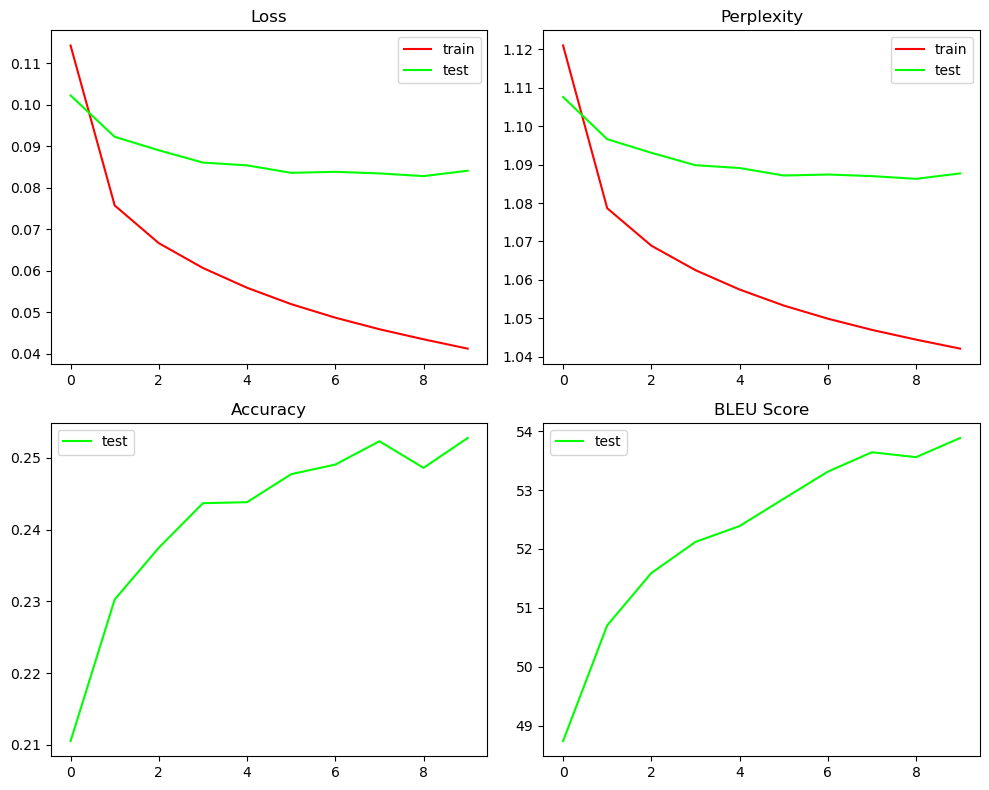

In [51]:
model = T5ForConditionalGeneration.from_pretrained('t5-small').to(device)

lr = 0.001
optimizer = AdamW(model.parameters(), lr=lr)

n_epochs = 10
start_epoch = 0

time_list = []
train_average_loss_list = []
test_average_loss_list = []
test_accuracies = []
train_perplexity_list = []
test_perplexity_list = []
test_bleu_scores = []

checkpoint_path = 'checkpoint_t5_1.pth'


try:
    checkpoint = torch.load(checkpoint_path, weights_only=False, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    start_epoch = checkpoint['epoch']  # 이어서 시작할 에포크
    time_list = checkpoint['time_list']
    train_average_loss_list = checkpoint['train_average_loss_list']
    test_average_loss_list = checkpoint['test_average_loss_list']
    test_accuracies = checkpoint['test_accuracies']
    train_perplexity_list = checkpoint['train_perplexity_list']
    test_perplexity_list = checkpoint['test_perplexity_list']
    test_bleu_scores = checkpoint['test_bleu_scores']
    for epoch in range(0, start_epoch):
        print(f"Epoch {epoch+1:3d} |"
        f" Time: {time_list[epoch]:.2f} seconds |"
        f" Train Loss: {train_average_loss_list[epoch]:.2f} |"
        f" Test Loss: {test_average_loss_list[epoch]:.2f} |"
        f" Test Acc: {test_accuracies[epoch]:.3f} |"
        f" Train Perplexity: {train_perplexity_list[epoch]:.2f} |"
        f" Test Perplexity: {test_perplexity_list[epoch]:.2f} |"
        f" Test BLEU Score: {test_bleu_scores[epoch]:.2f}")

    if start_epoch < n_epochs -1:
        print(f"이어서 시작~ {start_epoch + 1}.")
except FileNotFoundError:
    print("새롭게 시작~")


# 훈련 루프 수정
for epoch in range(start_epoch, n_epochs):
    start_time = time.time()  # 에포크 시작 시간 기록

    total_train_loss = 0.
    model.train()

    for batch in tqdm(train_loader):  # tqdm으로 진행 상황 시각화
        optimizer.zero_grad()  # 기울기 초기화
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        # T5 모델에서 직접 loss 계산
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss  # T5는 자체적으로 loss 반환

        # 역전파 및 최적화
        loss.backward()
        optimizer.step()

        total_train_loss += loss.item()


    # 한 에포크 끝난 뒤, 평균 학습 손실 & PPL
    train_average_loss = total_train_loss / len(train_loader)
    train_perplexity = torch.exp(torch.tensor(train_average_loss))
    train_average_loss_list.append(train_average_loss)
    train_perplexity_list.append(train_perplexity)

    with torch.no_grad():
        model.eval()

        # 정확도, BLEU 계산
        test_average_loss, test_perplexity, test_acc, test_bleu_score = evaluate_model(model, test_loader, tokenizer)

        test_average_loss_list.append(test_average_loss)
        test_accuracies.append(test_acc)
        test_bleu_scores.append(test_bleu_score)
        test_perplexity_list.append(test_perplexity)

        # 에포크 실행 시간 계산
        end_time = time.time()
        epoch_time = end_time - start_time
        time_list.append(epoch_time)


    # 체크포인트 저장
    torch.save({
        'epoch': epoch + 1,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'time_list': time_list,
        'train_average_loss_list': train_average_loss_list,
        'test_average_loss_list': test_average_loss_list,
        'test_accuracies': test_accuracies,
        'train_perplexity_list': train_perplexity_list,
        'test_perplexity_list': test_perplexity_list,
        'test_bleu_scores': test_bleu_scores

    }, checkpoint_path)


    # 결과 출력
    print(f"Epoch {epoch+1:3d} |"
    f" Time: {epoch_time:.2f} seconds |"
    f" Train Loss: {train_average_loss:.2f} |"
    f" Test Loss: {test_average_loss:.2f} |"
    f" Test Acc: {test_acc:.3f} |"
    f" Train Perplexity: {train_perplexity:.2f} |"
    f" Test Perplexity: {test_perplexity:.2f} |"
    f" Test BLEU Score: {test_bleu_score:.2f}")


# 서브플롯 생성 (2행 2열)
fig, axes = plt.subplots(2, 2, figsize=(10, 8))  # 2x2 서브플롯

# 서브플롯 위치에 그래프 그리기
plot_acc(axes[0, 0], "Loss", train_average_loss_list, test_average_loss_list)
plot_acc(axes[0, 1], "Perplexity", train_perplexity_list, test_perplexity_list)
plot_acc(axes[1, 0], "Accuracy", None, test_accuracies)
plot_acc(axes[1, 1], "BLEU Score", None, test_bleu_scores)

# 간격 조정
plt.tight_layout()
plt.show()

## ✅ 2. pre-trained + Decoder Fine-tuning (+lm_head)

In [49]:
model = T5ForConditionalGeneration.from_pretrained('t5-small').to(device)

# 인코더 가중치 고정 (디코더만 학습)
for param in model.encoder.parameters():
    param.requires_grad = False  # 인코더 가중치 고정

lr = 0.001
optimizer = AdamW(model.parameters(), lr=lr)

n_epochs = 10
start_epoch = 0

time_list = []
train_average_loss_list = []
test_average_loss_list = []
test_accuracies = []
train_perplexity_list = []
test_perplexity_list = []
test_bleu_scores = []

checkpoint_path = 'checkpoint_t5_2.pth'


try:
    checkpoint = torch.load(checkpoint_path, weights_only=False, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    start_epoch = checkpoint['epoch']  # 이어서 시작할 에포크
    time_list = checkpoint['time_list']
    train_average_loss_list = checkpoint['train_average_loss_list']
    test_average_loss_list = checkpoint['test_average_loss_list']
    test_accuracies = checkpoint['test_accuracies']
    train_perplexity_list = checkpoint['train_perplexity_list']
    test_perplexity_list = checkpoint['test_perplexity_list']
    test_bleu_scores = checkpoint['test_bleu_scores']
    for epoch in range(0, start_epoch):
        print(f"Epoch {epoch+1:3d} |"
        f" Time: {time_list[epoch]:.2f} seconds |"
        f" Train Loss: {train_average_loss_list[epoch]:.2f} |"
        f" Test Loss: {test_average_loss_list[epoch]:.2f} |"
        f" Test Acc: {test_accuracies[epoch]:.3f} |"
        f" Train Perplexity: {train_perplexity_list[epoch]:.2f} |"
        f" Test Perplexity: {test_perplexity_list[epoch]:.2f} |"
        f" Test BLEU Score: {test_bleu_scores[epoch]:.2f}")

    if start_epoch < n_epochs -1:
        print(f"이어서 시작~ {start_epoch + 1}.")
except FileNotFoundError:
    print("새롭게 시작~")


# 훈련 루프 수정
for epoch in range(start_epoch, n_epochs):
    start_time = time.time()  # 에포크 시작 시간 기록

    total_train_loss = 0.
    model.train()

    for batch in tqdm(train_loader):  # tqdm으로 진행 상황 시각화
        optimizer.zero_grad()  # 기울기 초기화
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        # T5 모델에서 직접 loss 계산
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss  # T5는 자체적으로 loss 반환

        # 역전파 및 최적화
        loss.backward()
        optimizer.step()

        total_train_loss += loss.item()


    # 한 에포크 끝난 뒤, 평균 학습 손실 & PPL
    train_average_loss = total_train_loss / len(train_loader)
    train_perplexity = torch.exp(torch.tensor(train_average_loss))
    train_average_loss_list.append(train_average_loss)
    train_perplexity_list.append(train_perplexity)

    with torch.no_grad():
        model.eval()

        # 정확도, BLEU 계산
        test_average_loss, test_perplexity, test_acc, test_bleu_score = evaluate_model(model, test_loader, tokenizer)

        test_average_loss_list.append(test_average_loss)
        test_accuracies.append(test_acc)
        test_bleu_scores.append(test_bleu_score)
        test_perplexity_list.append(test_perplexity)

        # 에포크 실행 시간 계산
        end_time = time.time()
        epoch_time = end_time - start_time
        time_list.append(epoch_time)


    # 체크포인트 저장
    torch.save({
        'epoch': epoch + 1,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'time_list': time_list,
        'train_average_loss_list': train_average_loss_list,
        'test_average_loss_list': test_average_loss_list,
        'test_accuracies': test_accuracies,
        'train_perplexity_list': train_perplexity_list,
        'test_perplexity_list': test_perplexity_list,
        'test_bleu_scores': test_bleu_scores

    }, checkpoint_path)


    # 결과 출력
    print(f"Epoch {epoch+1:3d} |"
    f" Time: {epoch_time:.2f} seconds |"
    f" Train Loss: {train_average_loss:.2f} |"
    f" Test Loss: {test_average_loss:.2f} |"
    f" Test Acc: {test_acc:.3f} |"
    f" Train Perplexity: {train_perplexity:.2f} |"
    f" Test Perplexity: {test_perplexity:.2f} |"
    f" Test BLEU Score: {test_bleu_score:.2f}")


# 서브플롯 생성 (2행 2열)
fig, axes = plt.subplots(2, 2, figsize=(10, 8))  # 2x2 서브플롯

# 서브플롯 위치에 그래프 그리기
plot_acc(axes[0, 0], "Loss", train_average_loss_list, test_average_loss_list)
plot_acc(axes[0, 1], "Perplexity", train_perplexity_list, test_perplexity_list)
plot_acc(axes[1, 0], "Accuracy", None, test_accuracies)
plot_acc(axes[1, 1], "BLEU Score", None, test_bleu_scores)

# 간격 조정
plt.tight_layout()
plt.show()

새롭게 시작~


  0%|          | 2/2196 [00:18<5:30:58,  9.05s/it]


KeyboardInterrupt: 

## ✅ 3. none-trained T5

In [ ]:
from transformers import T5Config, T5ForConditionalGeneration
config = T5Config.from_pretrained('t5-small')
model = T5ForConditionalGeneration(config).to(device)

lr = 0.001
optimizer = AdamW(model.parameters(), lr=lr)

n_epochs = 10
start_epoch = 0

time_list = []
train_average_loss_list = []
test_average_loss_list = []
test_accuracies = []
train_perplexity_list = []
test_perplexity_list = []
test_bleu_scores = []

checkpoint_path = 'checkpoint_t5_3.pth'


try:
    checkpoint = torch.load(checkpoint_path, weights_only=False, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    start_epoch = checkpoint['epoch']  # 이어서 시작할 에포크
    time_list = checkpoint['time_list']
    train_average_loss_list = checkpoint['train_average_loss_list']
    test_average_loss_list = checkpoint['test_average_loss_list']
    test_accuracies = checkpoint['test_accuracies']
    train_perplexity_list = checkpoint['train_perplexity_list']
    test_perplexity_list = checkpoint['test_perplexity_list']
    test_bleu_scores = checkpoint['test_bleu_scores']
    for epoch in range(0, start_epoch):
        print(f"Epoch {epoch+1:3d} |"
        f" Time: {time_list[epoch]:.2f} seconds |"
        f" Train Loss: {train_average_loss_list[epoch]:.2f} |"
        f" Test Loss: {test_average_loss_list[epoch]:.2f} |"
        f" Test Acc: {test_accuracies[epoch]:.3f} |"
        f" Train Perplexity: {train_perplexity_list[epoch]:.2f} |"
        f" Test Perplexity: {test_perplexity_list[epoch]:.2f} |"
        f" Test BLEU Score: {test_bleu_scores[epoch]:.2f}")

    if start_epoch < n_epochs -1:
        print(f"이어서 시작~ {start_epoch + 1}.")
except FileNotFoundError:
    print("새롭게 시작~")


# 훈련 루프 수정
for epoch in range(start_epoch, n_epochs):
    start_time = time.time()  # 에포크 시작 시간 기록

    total_train_loss = 0.
    model.train()

    for batch in tqdm(train_loader):  # tqdm으로 진행 상황 시각화
        optimizer.zero_grad()  # 기울기 초기화
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        # T5 모델에서 직접 loss 계산
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss  # T5는 자체적으로 loss 반환

        # 역전파 및 최적화
        loss.backward()
        optimizer.step()

        total_train_loss += loss.item()


    # 한 에포크 끝난 뒤, 평균 학습 손실 & PPL
    train_average_loss = total_train_loss / len(train_loader)
    train_perplexity = torch.exp(torch.tensor(train_average_loss))
    train_average_loss_list.append(train_average_loss)
    train_perplexity_list.append(train_perplexity)

    with torch.no_grad():
        model.eval()

        # 정확도, BLEU 계산
        test_average_loss, test_perplexity, test_acc, test_bleu_score = evaluate_model(model, test_loader, tokenizer)

        test_average_loss_list.append(test_average_loss)
        test_accuracies.append(test_acc)
        test_bleu_scores.append(test_bleu_score)
        test_perplexity_list.append(test_perplexity)

        # 에포크 실행 시간 계산
        end_time = time.time()
        epoch_time = end_time - start_time
        time_list.append(epoch_time)


    # 체크포인트 저장
    torch.save({
        'epoch': epoch + 1,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'time_list': time_list,
        'train_average_loss_list': train_average_loss_list,
        'test_average_loss_list': test_average_loss_list,
        'test_accuracies': test_accuracies,
        'train_perplexity_list': train_perplexity_list,
        'test_perplexity_list': test_perplexity_list,
        'test_bleu_scores': test_bleu_scores

    }, checkpoint_path)


    # 결과 출력
    print(f"Epoch {epoch+1:3d} |"
    f" Time: {epoch_time:.2f} seconds |"
    f" Train Loss: {train_average_loss:.2f} |"
    f" Test Loss: {test_average_loss:.2f} |"
    f" Test Acc: {test_acc:.3f} |"
    f" Train Perplexity: {train_perplexity:.2f} |"
    f" Test Perplexity: {test_perplexity:.2f} |"
    f" Test BLEU Score: {test_bleu_score:.2f}")


# 서브플롯 생성 (2행 2열)
fig, axes = plt.subplots(2, 2, figsize=(10, 8))  # 2x2 서브플롯

# 서브플롯 위치에 그래프 그리기
plot_acc(axes[0, 0], "Loss", train_average_loss_list, test_average_loss_list)
plot_acc(axes[0, 1], "Perplexity", train_perplexity_list, test_perplexity_list)
plot_acc(axes[1, 0], "Accuracy", None, test_accuracies)
plot_acc(axes[1, 1], "BLEU Score", None, test_bleu_scores)

# 간격 조정
plt.tight_layout()
plt.show()